# Robustness Analysis for LeNER-Br (Portuguese Legal NER)

This notebook evaluates robustness of the fine-tuned Portuguese BERT NER model on LeNER-Br without retraining. Perturbations simulate noise, masking, and semantic-preserving substitutions to stress test entity extraction in legal text.

## 1. Setup and Model Loading

Load libraries, dataset, label space, tokenizer, and the fine-tuned model saved from the training notebook.

In [73]:
import os
import random
import string
import unicodedata
from collections import Counter, defaultdict

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Reproducibility for perturbations
random.seed(42)
np.random.seed(42)


device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## 2. Dataset and Label Space

Load LeNER-Br, rebuild the label mapping used during training, and keep the tag-to-ID mapping explicit.

In [74]:
dataset_id = "peluz/lener_br"
hf_token = os.getenv("HF_TOKEN")

lener = load_dataset(dataset_id, token=hf_token)
print(lener)

ner_feature = lener["train"].features["ner_tags"]
label_list = ner_feature.feature.names
num_labels = len(label_list)
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

tag2id = {
    "O": 0,
    "B-ORGANIZACAO": 1,
    "I-ORGANIZACAO": 2,
    "B-PESSOA": 3,
    "I-PESSOA": 4,
    "B-TEMPO": 5,
    "I-TEMPO": 6,
    "B-LOCAL": 7,
    "I-LOCAL": 8,
    "B-LEGISLACAO": 9,
    "I-LEGISLACAO": 10,
    "B-JURISPRUDENCIA": 11,
    "I-JURISPRUDENCIA": 12,
}
print("Labels:", label_list)


c:\Users\diogo\Repositorios\ner_smalllm_project\.venv\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for peluz/lener_br contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/peluz/lener_br
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})
Labels: ['O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-PESSOA', 'I-PESSOA', 'B-TEMPO', 'I-TEMPO', 'B-LOCAL', 'I-LOCAL', 'B-LEGISLACAO', 'I-LEGISLACAO', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA']


## 3. Robustness Evaluation Pipeline

Load the fine-tuned Portuguese BERT model, define generic NER inference, and a reusable robustness evaluator that applies perturbations and computes seqeval metrics.

In [75]:
metric = evaluate.load("seqeval")

model_dir = r"C:\Users\diogo\Repositorios\ner_smalllm_project\notebooks\models\lenerbr_bert_base"

model = AutoModelForTokenClassification.from_pretrained(model_dir)
model.config.id2label = id2label
model.config.label2id = label2id
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_dir)

MAX_LENGTH = int(
    min(
        getattr(tokenizer, "model_max_length", 512),
        getattr(model.config, "max_position_embeddings", 512),
        512,
    )
)
STRIDE = 64  # overlap entre janelas; pode ajustar (32, 64, 128)


def predict_word_logits_sliding(
    tokens, model, tokenizer, num_labels, device, max_length=MAX_LENGTH, stride=STRIDE
):
    model.eval()

    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_overflowing_tokens=True,
        stride=stride,
        truncation=True,
        max_length=max_length,
        return_tensors=None,
        padding=False,
    )

    n_words = len(tokens)
    agg = np.zeros((n_words, num_labels), dtype=np.float32)
    counts = np.zeros((n_words,), dtype=np.float32)

    n_windows = len(encoding["input_ids"])

    for w in range(n_windows):
        input_ids = (
            torch.tensor(encoding["input_ids"][w], dtype=torch.long)
            .unsqueeze(0)
            .to(device)
        )
        attention_mask = (
            torch.tensor(encoding["attention_mask"][w], dtype=torch.long)
            .unsqueeze(0)
            .to(device)
        )

        word_ids = encoding.word_ids(w)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        logits = (
            outputs.logits.squeeze(0).detach().cpu().numpy()
        )  

        for pos, wid in enumerate(word_ids):
            if wid is None:
                continue
            agg[wid] += logits[pos]
            counts[wid] += 1.0

    if (counts == 0).any():
        missing = np.where(counts == 0)[0].tolist()
        raise RuntimeError(f"[sliding] Missing logits for word indices: {missing}")

    agg = agg / counts[:, None]
    return agg


def ner_predict_sliding(
    tokens, model, tokenizer, label_list, device, max_length=MAX_LENGTH, stride=STRIDE
):
    num_labels = len(label_list)
    logits = predict_word_logits_sliding(
        tokens=tokens,
        model=model,
        tokenizer=tokenizer,
        num_labels=num_labels,
        device=device,
        max_length=max_length,
        stride=stride,
    )
    pred_ids = logits.argmax(axis=1)
    return [label_list[i] for i in pred_ids]


def ner_predict(tokens, model, tokenizer, label_list):
    '''Runs NER on pre-tokenized input and returns one label per original token.'''
    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
    )
    word_ids = encoding.word_ids()
    encoding = {k: v.to(device) for k, v in encoding.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
    pred_ids = outputs.logits.argmax(-1).cpu().numpy()[0]

    preds = []
    seen = set()
    for idx, word_id in enumerate(word_ids):
        if word_id is None or word_id in seen:
            continue
        seen.add(word_id)
        preds.append(label_list[pred_ids[idx]])
    return preds


def evaluate_robustness(dataset, perturb_fn, metric, label_list, max_examples=None):
    '''Applies a perturbation to each example, runs NER, and computes seqeval metrics.'''
    preds, refs = [], []
    for idx, ex in enumerate(dataset):
        if max_examples is not None and idx >= max_examples:
            break
        tokens = ex["tokens"]
        gold_labels = [label_list[t] for t in ex["ner_tags"]]

        perturbed_tokens = perturb_fn(tokens)
        pred_labels = ner_predict_sliding(
            perturbed_tokens, model, tokenizer, label_list, device
        )

        max_len = max(len(pred_labels), len(gold_labels))
        pred_aligned = pred_labels + ["O"] * (max_len - len(pred_labels))
        gold_aligned = gold_labels + ["O"] * (max_len - len(gold_labels))

        preds.append(pred_aligned)
        refs.append(gold_aligned)

    return metric.compute(predictions=preds, references=refs)


def evaluate_synonym_robustness(
    dataset,
    prob,
    metric,
    label_list,
    max_examples=200,
):
    preds, refs = [], []
    total_changed = 0
    total_tokens = 0

    for idx, ex in enumerate(dataset):
        if idx >= max_examples:
            break

        tokens = ex["tokens"]
        gold_labels = [label_list[t] for t in ex["ner_tags"]]

        perturbed_tokens, n_changed = synonym_noise_with_stats(tokens, prob=prob)

        total_changed += n_changed
        total_tokens += len(tokens)

        pred_labels = ner_predict(perturbed_tokens, model, tokenizer, label_list)

        # alinhamento simples (igual ao resto do notebook)
        max_len = max(len(pred_labels), len(gold_labels))
        preds.append(pred_labels + ["O"] * (max_len - len(pred_labels)))
        refs.append(gold_labels + ["O"] * (max_len - len(gold_labels)))

    metrics = metric.compute(predictions=preds, references=refs)

    return {
        "overall_f1": metrics["overall_f1"],
        "avg_synonym_rate": total_changed / total_tokens if total_tokens else 0.0,
    }

## 4. Lexical and Orthographic Noise

Character-level and accent perturbations to test sensitivity to surface form changes.

In [76]:
def random_char_noise(token: str, prob: float = 0.1) -> str:
    '''Randomly replaces characters in a token with ASCII letters with given probability.'''
    letters = string.ascii_letters
    noisy = []
    for ch in token:
        if random.random() < prob:
            noisy.append(random.choice(letters))
        else:
            noisy.append(ch)
    return "".join(noisy)


def remove_accents(token: str) -> str:
    '''Removes diacritic marks from a token (Portuguese accent stripping).'''
    nfkd = unicodedata.normalize("NFKD", token)
    return "".join([c for c in nfkd if not unicodedata.combining(c)])


def apply_char_noise(tokens, prob: float = 0.1):
    return [random_char_noise(t, prob=prob) for t in tokens]


def apply_accent_removal(tokens):
    return [remove_accents(t) for t in tokens]


## 5. Context and Masking Perturbations

Inject filler tokens or mask existing ones to simulate context drift and missing evidence.

In [77]:
def insert_noise_words(tokens, prob: float = 0.1):
    '''Inserts random filler tokens between words with a given probability.'''
    noise_words = ["xxx", "lorem", "teste", "ruido"]
    output = []
    for tok in tokens:
        output.append(tok)
        if random.random() < prob:
            output.append(random.choice(noise_words))
    return output


def mask_tokens(tokens, prob: float = 0.15):
    '''Randomly replaces tokens with [MASK] with a given probability.'''
    mask_tok = tokenizer.mask_token if tokenizer.mask_token else "[MASK]"
    return [mask_tok if random.random() < prob else t for t in tokens]


## 6. Synonym-based Perturbations (Careful Design)

Inspect frequent tokens per entity to craft conservative synonym substitutions that preserve meaning.

In [78]:
label_token_freq = defaultdict(Counter)

for ex in lener["train"]:
    tokens = ex["tokens"]
    tags = ex["ner_tags"]
    for tok, tag_id in zip(tokens, tags):
        label_token_freq[tag_id][tok] += 1

for tag_id in range(1, 13):  # skip 'O'
    label_name = label_list[tag_id]
    print(f"=== Top tokens for {label_name} (id={tag_id}) ===")
    for tok, count in label_token_freq[tag_id].most_common(20):
        print(f"{tok}	{count}")


=== Top tokens for B-ORGANIZACAO (id=1) ===
Supremo	190
Ministério	125
Superior	89
Segunda	77
Tribunal	72
ICP-Brasil	71
TCU	65
Infraestrutura	65
STF	51
Plenário	47
MINISTÉRIO	41
Distrito	37
STJ	36
MPM	36
Conselho	35
União	34
2ª	33
Exército	33
Câmara	28
Secretaria	26
=== Top tokens for I-ORGANIZACAO (id=2) ===
de	384
Tribunal	310
Federal	285
do	192
da	161
Turma	134
Justiça	118
Público	114
Brasileira	86
Militar	80
Chaves	72
Públicas	72
e	60
Câmara	59
TURMA	48
Cível	48
FEDERAL	48
DE	45
TRIBUNAL	43
PÚBLICO	41
=== Top tokens for B-PESSOA (id=3) ===
LUIZ	33
José	31
Carlos	28
Luiz	28
Luis	28
Robsmar	24
RAFAEL	23
JOSÉ	22
ALEXANDRE	22
MARCO	21
Cármen	20
André	18
Jorge	18
Ricardo	18
Marco	18
Dias	18
Rosa	18
Celso	17
Napoleão	16
Anderson	16
=== Top tokens for I-PESSOA (id=4) ===
de	161
DE	137
da	62
Silva	60
DA	41
Oliveira	34
Carlos	32
LIMA	32
PEREIRA	29
Gomes	29
Aurélio	28
AURÉLIO	27
Mattos	26
FUX	26
SILVA	25
Lima	25
Filho	25
Fux	24
Ferreira	21
Souza	21
=== Top tokens for B-TEMPO (id=5) ===
24/08

In [79]:
SYNONYM_MAP = {
    # =======================
    # Titles / persons
    # =======================
    "MINISTRO": "AUTORIDADE",
    "MINISTRA": "AUTORIDADE",
    "JUIZ": "MAGISTRADO",
    "JUÍZA": "MAGISTRADA",
    "RELATOR": "MAGISTRADO",
    "RELATORA": "MAGISTRADA",
    # =======================
    # Organizations / courts
    # =======================
    "TRIBUNAL": "CORTE",
    "PLENÁRIO": "SESSAO",
    "CÂMARA": "COLEGIO",
    "CAMARA": "COLEGIO", 
    "TURMA": "PAINEL",
    # =======================
    # Legislation
    # =======================
    "LEI": "NORMA",
    "ARTIGO": "DISPOSITIVO",
    "ART": "DISP",
    "ACÓRDÃO": "DECISAO",
    "ACORDAO": "DECISAO",
    # =======================
    # Common uppercase variants
    # =======================
    "LEI": "NORMA",
    "LEIS": "NORMAS",
    "ARTIGO": "DISPOSITIVO",
    "ARTIGOS": "DISPOSITIVOS",
    "SÚMULA": "ENUNCIADO",
}


def synonym_noise_with_stats(tokens, prob: float = 1.0):
    out = []
    n_changed = 0

    for tok in tokens:
        key = remove_accents(tok).upper()
        if key in SYNONYM_MAP and random.random() < prob:
            out.append(SYNONYM_MAP[key])
            n_changed += 1
        else:
            out.append(tok)

    return out, n_changed

## 7. Quantitative Robustness Results

Evaluate baseline vs. multiple perturbations on a validation subset (first 200 examples). Sweep noise levels to draw robustness curves and quantify how quickly performance drops.


In [80]:
val_subset = lener["validation"].select(range(200))

noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]

baseline_results = evaluate_robustness(
    val_subset, lambda x: x, metric, label_list, max_examples=200
)
baseline_f1 = baseline_results["overall_f1"]

curve_rows = []
synonym_rows = []  # <-- guarda stats do sinônimo

# ataques "normais" (que devolvem só tokens)
attack_builders = {
    "Char noise": lambda prob: (lambda toks: apply_char_noise(toks, prob=prob)),
    "Word insertion": lambda prob: (lambda toks: insert_noise_words(toks, prob=prob)),
    "Masking": lambda prob: (lambda toks: mask_tokens(toks, prob=prob)),
}

# 1) Rodar ataques normais com evaluate_robustness
for attack_name, builder in attack_builders.items():
    for prob in noise_levels:
        perturb_fn = builder(prob)
        result = evaluate_robustness(
            val_subset, perturb_fn, metric, label_list, max_examples=200
        )
        curve_rows.append(
            {
                "attack": attack_name,
                "noise_level": prob,
                "f1": result["overall_f1"],
            }
        )

# 2) Rodar Synonym noise com evaluate_synonym_robustness (com stats)
for prob in noise_levels:
    if prob == 0:
        f1 = baseline_f1
        avg_rate = 0.0
    else:
        result = evaluate_synonym_robustness(
            val_subset,
            prob=prob,
            metric=metric,
            label_list=label_list,
            max_examples=200,
        )
        f1 = result["overall_f1"]
        avg_rate = result["avg_synonym_rate"]

    curve_rows.append({"attack": "Synonym noise", "noise_level": prob, "f1": f1})
    synonym_rows.append({"noise_level": prob, "f1": f1, "avg_synonym_rate": avg_rate})

df_curves = (
    pd.DataFrame(curve_rows)
    .sort_values(["attack", "noise_level"])
    .reset_index(drop=True)
)

print(f"Baseline F1 (no noise): {baseline_f1:.4f}")

# Tabela completa: uma linha por ataque, uma coluna por nível
df_levels = (
    df_curves.assign(noise_pct=(df_curves["noise_level"] * 100).round().astype(int))
    .pivot(index="attack", columns="noise_pct", values="f1")
    .sort_index(axis=1)
)

# renomeia colunas para f1_pX
df_levels.columns = [f"f1_p{c}" for c in df_levels.columns]

# delta final (p30 - p0)
df_levels["delta_p30_minus_p0"] = df_levels["f1_p30"] - df_levels["f1_p0"]

df_levels

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Baseline F1 (no noise): 0.8693


,f1_p0,f1_p5,f1_p10,f1_p20,f1_p30,delta_p30_minus_p0
attack,,,,,,
Char noise,0.86931,0.794030,0.680535,0.442177,0.250000,-0.619310
Masking,0.86931,0.848214,0.767407,0.696594,0.448148,-0.421162
Synonym noise,0.86931,0.861357,0.866373,0.863836,0.856305,-0.013005
Word insertion,0.86931,0.227074,0.136827,0.057554,0.028818,-0.840491


In [81]:
df_syn_stats = pd.DataFrame(synonym_rows)

df_syn_stats["noise_pct"] = (df_syn_stats["noise_level"] * 100).round().astype(int)
df_syn_stats = df_syn_stats.rename(
    columns={
        "noise_pct": "noise_%",
        "avg_synonym_rate": "avg_synonym_substitution_rate",
    }
)

df_syn_stats

,noise_level,f1,avg_synonym_substitution_rate,noise_%
0,0.00,0.869310,0.000000,0
1,0.05,0.861357,0.001073,5
2,0.10,0.866373,0.001687,10
3,0.20,0.863836,0.003067,20
4,0.30,0.856305,0.006287,30


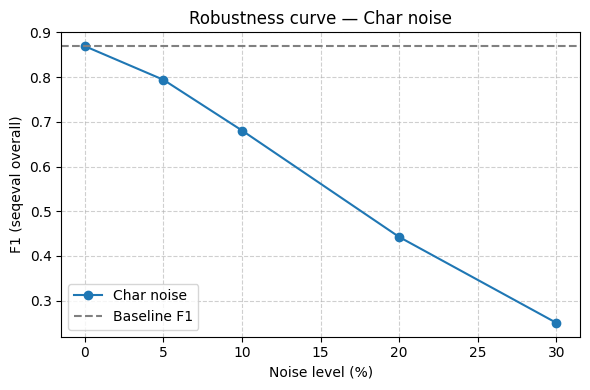

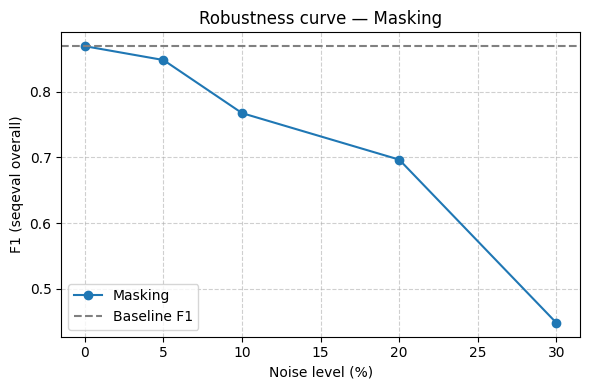

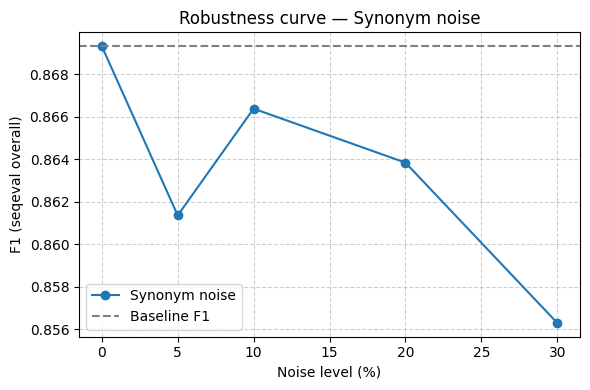

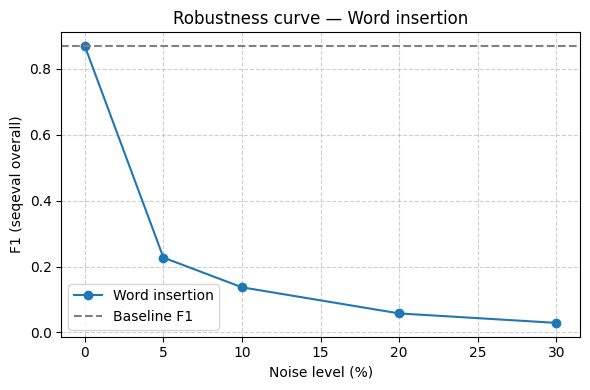

In [82]:
for attack_name in df_curves["attack"].unique():
    attack_df = df_curves[df_curves["attack"] == attack_name].sort_values("noise_level")


    plt.figure(figsize=(6, 4))
    plt.plot(
        attack_df["noise_level"] * 100,
        attack_df["f1"],
        marker="o",
        label=attack_name,
    )
    plt.axhline(
        y=baseline_f1,
        linestyle="--",
        color="gray",
        label="Baseline F1",
    )
    plt.xlabel("Noise level (%)")
    plt.ylabel("F1 (seqeval overall)")
    plt.title(f"Robustness curve — {attack_name}")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.legend()
    plt.show()

## 8. Qualitative Examples

Inspect a few validation sentences before and after perturbations to see how entity predictions change.

In [ ]:
def format_predictions(tokens, labels, pad_token="<PAD>"):
    lines = []
    for t, l in zip(tokens, labels):
        lines.append(f"{t:<20} {l}")
    return "\n".join(lines)


def ensure_tokens(x):
    if isinstance(x, tuple) and len(x) >= 1:
        x = x[0]

    # Garantia mínima
    if not isinstance(x, list):
        raise TypeError(f"Perturbation must return List[str], got {type(x)}")

    # Garante que tudo é string
    x = [str(t) for t in x]
    return x


sample_indices = [0, 1, 2]

perturbations = {
    "Accent removal": lambda toks: apply_accent_removal(toks),
    "Char noise (p=0.1)": lambda toks: apply_char_noise(toks, prob=0.1),
    "Synonym noise (p=0.3)": lambda toks: synonym_noise_with_stats(toks, prob=0.3),
}

for idx in sample_indices:
    ex = val_subset[idx]
    tokens = ex["tokens"]

    pred_base = ner_predict(tokens, model, tokenizer, label_list)
    print(f"\n=== Example {idx} ===")
    print("Tokens and baseline predictions:")
    print(format_predictions(tokens, pred_base))

    for name, fn in perturbations.items():
        pert_out = fn(tokens)
        pert_tokens = ensure_tokens(pert_out)  

        pred_pert = ner_predict(pert_tokens, model, tokenizer, label_list)

        max_len = max(len(pert_tokens), len(pred_pert))
        padded_tokens = pert_tokens + ["<PAD>"] * (max_len - len(pert_tokens))
        padded_preds = pred_pert + ["O"] * (max_len - len(pred_pert))

        print(f"\n{name}:")
        print(format_predictions(padded_tokens, padded_preds))


=== Example 0 ===
Tokens and baseline predictions:
E                    O
M                    O
E                    O
N                    O
T                    O
A                    O
Órgão                O
:                    O
8ª                   B-ORGANIZACAO
TURMA                I-ORGANIZACAO
CÍVEL                I-ORGANIZACAO
Classe               O
:                    O
APELAÇÃO             O
CÍVEL                O
N                    O
.                    O
Processo             O
:                    O
20150110436469APC    B-JURISPRUDENCIA
(                    O
0012843-03.2015.8.07.0001 B-JURISPRUDENCIA
)                    O
Apelante             O
(                    O
s                    O
)                    O
:                    O
BRASILIA             B-ORGANIZACAO
CURSOS               I-ORGANIZACAO
E                    I-ORGANIZACAO
CONCURSOS            I-ORGANIZACAO
LTDA                 I-ORGANIZACAO
GRANCURSOS           B-ORGANIZACAO
ESCOLA               I-

## 9. Discussion and Conclusions

The robustness evaluation provides a detailed profile of how the legal-domain NER model reacts to different perturbations applied to the validation dataset. Using the clean data as a baseline (F1 ≈ **0.869**), we analyzed not only isolated perturbation points, but also **robustness curves** that show how performance degrades as noise intensity increases.

This curve-based analysis reveals both the **severity** and the **rate of degradation** under different types of noise, providing a more complete picture of model behavior.

---

### **Character Noise**
Character-level corruption leads to a **steep and monotonic performance drop** as noise increases. Even small amounts of noise cause noticeable degradation, and higher levels rapidly collapse F1.

This confirms that the model is highly sensitive to spelling and subword integrity, a known limitation of WordPiece-based tokenization in legal text.

**Hypotheses for improving robustness:**
- Character-level noise augmentation during training  
- Finer-grained or byte-level tokenization  
- Contrastive training between clean and corrupted inputs  

---

### **Masking**
Masking shows a **more gradual degradation curve**. Performance remains relatively high at low masking rates, indicating that contextual cues can partially compensate for missing tokens. However, as masking increases, especially when entity anchors are removed, performance degrades substantially.

**Hypotheses for improvement:**
- Entity-aware masking strategies  
- Higher masking rates during pretraining  
- Joint MLM + NER objectives  

---

### **Synonym Substitution**
Synonym substitution produces an almost **flat robustness curve**, with only minimal performance variation even at higher substitution rates. This indicates strong semantic robustness: the model relies on contextual and semantic patterns rather than memorized surface forms.

Minor fluctuations around the baseline are expected and do not indicate instability.

**Hypothesis for improvement:**
- Controlled synonym-based augmentation to further strengthen semantic invariance  

---

### **Word Insertion**
Word insertion is the most destructive perturbation. Even very small insertion rates cause **dramatic and immediate performance collapse**, revealing extreme sensitivity to structural noise.

This highlights a critical weakness of sequence-based attention mechanisms: without training-time exposure to clutter, the model cannot distinguish relevant tokens from irrelevant ones.

**Hypotheses for improvement:**
- Training with synthetic insertion noise  
- Adversarial training with structural perturbations  
- Noise-filtering or segmentation preprocessing  
- Architectures more robust to cluttered sequences  

---

## **Overall Interpretation**

The robustness curves reveal a clear hierarchy of vulnerabilities:

- **High robustness** to semantic-preserving changes (synonyms)  
- **Moderate robustness** to missing information (masking)  
- **Low robustness** to orthographic corruption (character noise)  
- **Extreme vulnerability** to structural noise (word insertion)

These findings align with known behaviors of Transformer-based NER systems and reinforce the need for robustness-oriented training strategies.

---

## **Concluding Remarks and Future Work**

By extending robustness evaluation from single-point measurements to full noise-level curves, we obtain a more comprehensive and realistic view of model behavior. The results provide concrete guidance for future improvements, including targeted data augmentation, tokenizer design choices, and adversarial training strategies tailored to legal-domain text.
